<a name="1common."></a>
## Содержание:
* [1. Описание проекта, описание данных, загрузка и импорт библиотек](#1.)
* [2. Предобработка данных](#2.)
* [3. Исследовательский анализ данных](#3.)
     - [2.1. Прогнозное значение продаж на 2011 год](#2.1.)
     - [2.2. Наиболее оборачиваемые группы](#2.2.)
     - [2.3. Существующие тенденции. Сезонность](#2.3.)
     - [2.4. Продажи товаров по всем ценовым группам за последний год](#2.4.)
     - [2.5. Математическая модель](#2.5.)
* [4. Общий вывод](#4.)

 <a name="1."><a/><br/>
    <font size ="5"><b>1. Описание проекта, описание данных, загрузка и импорт библиотек</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Имеются данные по продажам товаров (Т) в штуках понедельно за 4 года в одной из торговых точек. Необходимо:
* просчитать прогнозное значение продаж Т на следующий год, так же понедельно;
* определить наиболее оборачиваемые группы Т и просчитать их доли;
* выявить существующие тенденции: проследить, наблюдается ли сезонность, если да, то описать ее, определить общий тренд продаж и т.д.
* построить диаграмму, отображающую продажи Т по всем ценовым группам за последний год (все должно быть в одной диаграмме);
* построить математическую модель, описывающую продажи в торговой точке.

In [537]:
# для работы с таблицами
import pandas as pd

# для работы с математическими опперациями
import numpy as np

# для графиков
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

# для мат. модели
import scipy.stats as stats

import warnings
warnings.simplefilter('ignore')

In [463]:
df = pd.read_excel(
    'C:/Users/User/Desktop/Python/pochta.xlsx', sheet_name='Задание')

# приведем таблицу к удобному виду
df = df.dropna(axis=1, how='all')
df.columns = ['number_week', 'week', 'econom', 'fine', 'premium']
df = df[4:].reset_index()
df = df.drop(['index', 'number_week'], 1)
df.head()

,week,econom,fine,premium
0,Неделя с 10.04.2006 ',97,50,4
1,Неделя с 17.04.2006 ',94,45,12
2,Неделя с 24.04.2006 ',79,41,14
3,Неделя с 01.05.2006 ',133,62,12
4,Неделя с 08.05.2006 ',99,63,9


In [464]:
# функция для поиска пропусков и их количества от общего числа данных
def missing_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Пропуски", 1: "% от общего"})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns['Пропуски'] != 0].sort_values(
        "% от общего", ascending=False).round(1)
    print("Данная таблица имеет " + str(df.shape[1]) + " столбцов.\n"
          "В ней " + str(mis_val_table_ren_columns.shape[0]) +
          " столбцов с пропусками.")
    print('В ней', len(df), 'строк')
    print('Данная таблица имеет', df.duplicated().sum(), 'дубликатов')
    print("Дубликатов = {:.1%}".format(df.duplicated().sum() / len(df)))
    print(df.dtypes)
    return mis_val_table_ren_columns


missing_table(df)

Данная таблица имеет 4 столбцов.
В ней 0 столбцов с пропусками.
В ней 209 строк
Данная таблица имеет 0 дубликатов
Дубликатов = 0.0%
week       object
econom     object
fine       object
premium    object
dtype: object


,Пропуски,% от общего


 <a name="2."><a/><br/>
    <font size ="5"><b>2. Предобработка данных</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [465]:
# приведем данные к нужным типам
columns_numeric = ['econom', 'fine', 'premium']
for column in columns_numeric:
    df[column] = pd.to_numeric(df[column])

# переведем недели в тип datetime
df['data'] = df['week'].str.split(' ', expand=True)[2]
df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 5 columns):
week       209 non-null object
econom     209 non-null int64
fine       209 non-null int64
premium    209 non-null int64
data       209 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 8.2+ KB


In [466]:
# получим данные месяца, года и номера недели
df['year'] = pd.DatetimeIndex(df['data']).year
df['month'] = pd.DatetimeIndex(df['data']).month
df['week_of_year'] = pd.DatetimeIndex(df['data']).weekofyear

# отсортируем по возрастанию даты
df = df.sort_values(by='data')
df.head()

,week,econom,fine,premium,data,year,month,week_of_year
0,Неделя с 10.04.2006 ',97,50,4,2006-04-10,2006,4,15
1,Неделя с 17.04.2006 ',94,45,12,2006-04-17,2006,4,16
2,Неделя с 24.04.2006 ',79,41,14,2006-04-24,2006,4,17
3,Неделя с 01.05.2006 ',133,62,12,2006-05-01,2006,5,18
4,Неделя с 08.05.2006 ',99,63,9,2006-05-08,2006,5,19


In [481]:
# добавим новую категорию 'Сезоны'
def time_year(month):
    if month == 12 or month < 4:
        return 'Зима'
    if month > 3 and month < 6:
        return 'Весна'
    if month > 5 and month < 9:
        return 'Лето'
    if month > 8 and month < 12:
        return 'Осень'


df['season'] = df['month'].apply(time_year)
df.head()

,week,econom,fine,premium,data,year,month,week_of_year,season
0,Неделя с 10.04.2006 ',97,50,4,2006-04-10,2006,4,15,Весна
1,Неделя с 17.04.2006 ',94,45,12,2006-04-17,2006,4,16,Весна
2,Неделя с 24.04.2006 ',79,41,14,2006-04-24,2006,4,17,Весна
3,Неделя с 01.05.2006 ',133,62,12,2006-05-01,2006,5,18,Весна
4,Неделя с 08.05.2006 ',99,63,9,2006-05-08,2006,5,19,Весна


<a name="2."><a/><br/>
    <font size ="5"><b>2. Исследовательский анализ данных</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)
    <a name="2.1."><a/><br/>
    <font size ="4"><b>2.1. Прогнозное значение продаж на 2011 год</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

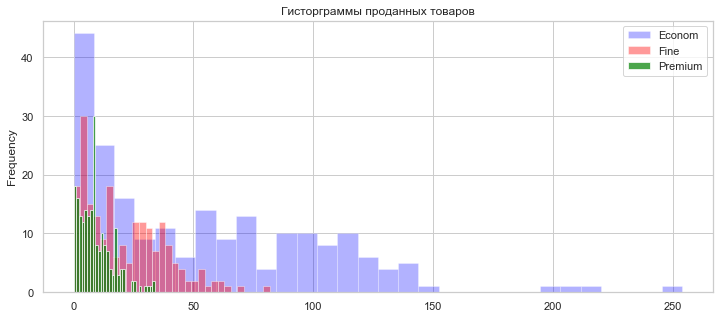

In [467]:
# посмотрим на распределение ценновых групп
ax = df['econom'].plot(kind='hist', bins=30, grid=True,
                       figsize=(12, 5), color='blue', alpha=0.3)
ax1 = df['fine'].plot(kind='hist', bins=30, grid=True,
                      figsize=(12, 5), ax=ax, color='red', alpha=0.4)
df['premium'].plot(kind='hist', bins=30, grid=True,
                   figsize=(12, 5), ax=ax, color='green', alpha=0.7)
plt.legend(['Econom', 'Fine', 'Premium'])
plt.title("Гисторграммы проданных товаров")
plt.show()

Очень много выбросов. Это исказит наш прогноз на следующий год. Посмотрим на диаграмму размаха.

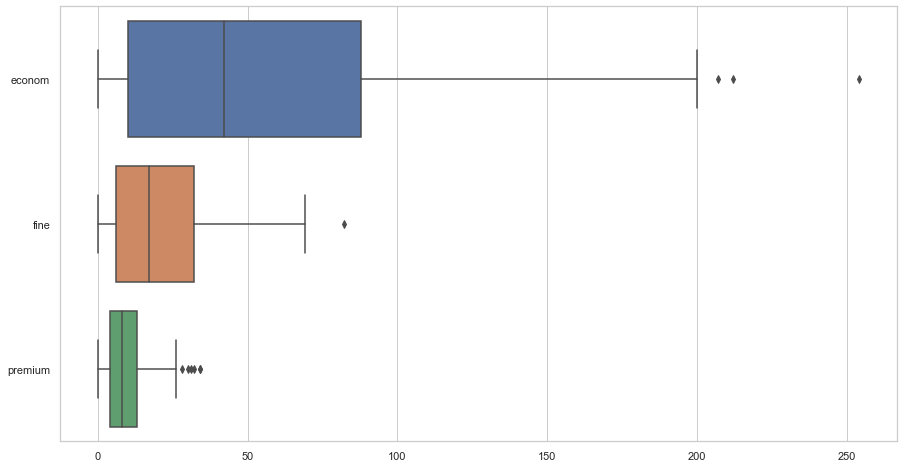

In [468]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[['econom', 'fine', 'premium']], orient='h')
plt.show()

In [521]:
# избавимся от выбросов, данные запишем в df_clear
df_clear = df.query('econom <= 200 and fine <= 65 and premium <= 25')

# на основании уже получившейся таблицы, сгруппируем данные понедельно и получим средние значения
predict = df_clear.groupby('week_of_year')[
    ['econom', 'fine', 'premium']].mean().reset_index()
predict[['econom', 'fine', 'premium']] = predict[[
    'econom', 'fine', 'premium']].astype(int)
predict.head()

,week_of_year,econom,fine,premium
0,1,5,8,4
1,2,7,4,4
2,3,4,4,4
3,4,10,5,5
4,5,12,8,5


Эти данные и будут являться прогнозом на следующий год

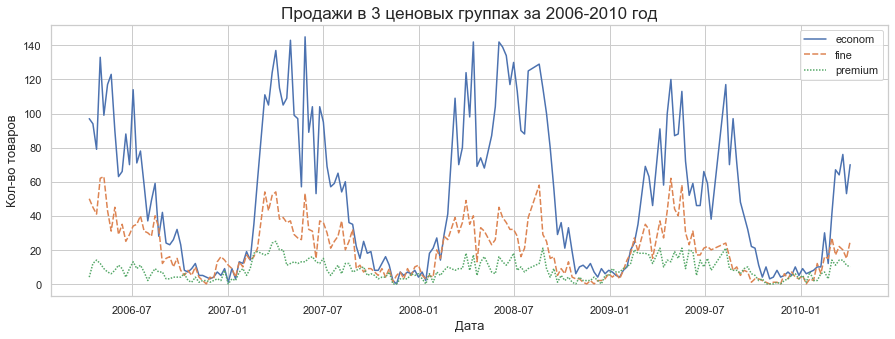

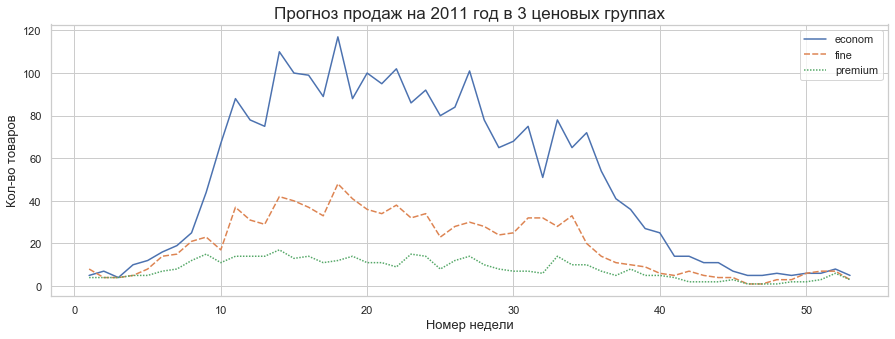

In [534]:
plt.figure(figsize=(15, 5))
sns.set(style="whitegrid")
sns.lineplot(
    data=df1[['data', 'econom', 'fine', 'premium']].set_index(['data']))
plt.xlabel('Дата', fontsize=13)
plt.ylabel('Кол-во товаров', fontsize=13)
plt.title('Продажи в 3 ценовых группах за 2006-2010 год', fontsize=17)
plt.show()
plt.figure(figsize=(15, 5))
sns.lineplot(data=predict[['week_of_year', 'econom',
                           'fine', 'premium']].set_index(['week_of_year']))
plt.xlabel('Номер недели', fontsize=13)
plt.ylabel('Кол-во товаров', fontsize=13)
plt.title('Прогноз продаж на 2011 год в 3 ценовых группах', fontsize=17)
plt.show()

### Вывод:

Данные ведут себя достаточно статично. Прослеживается сезонная тенденция. Повторяющийся восходящий тренд к лету и нисходящий тренд к зиме.

<a name="2.2."><a/><br/>
    <font size ="4"><b>2.2. Наиболее оборачиваемые группы</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [535]:
fig = go.Figure(data=[go.Pie(labels=['econom', 'fine', 'premium'], values=[
                df['econom'].sum(), df['fine'].sum(), df['premium'].sum()])])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_text="Доля продаж ценовых групп товаров 2006-2010")
fig.show()

### Вывод:

Товары ценовой группы эконом бесспорно лидируют по количеству оборота.

<a name="2.3."><a/><br/>
    <font size ="4"><b>2.3. Существующие тенденции. Сезонность</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)    

In [503]:
fig = go.Figure(go.Bar(x=new_df['season'], y=new_df['econom'], name='Econom'))
fig.add_trace(go.Bar(x=new_df['season'], y=new_df['fine'], name='Fine'))
fig.add_trace(go.Bar(x=new_df['season'], y=new_df['premium'], name='Premium'))

fig.update_layout(barmode='stack', title="Средние продажи по сезонам")
fig.update_yaxes(title="Товары")
fig.show()

### Вывод:

Лето и Весна в 2-3 раза превосходят по продажам осенне-зимний период

<a name="2.4."><a/><br/>
    <font size ="4"><b>2.4. Продажи товаров по всем ценовым группам за последний год</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)    

Данные за 2010 год неполные, поэтому возьмем данные за 2009 год

In [536]:
# посмотрим на график продаж за 2009 год
df_2009 = df.query("year == 2009")
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df_2009['data'],
    y=df_2009['econom'],
    name='Econom',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=df_2009['data'],
    y=df_2009['fine'],
    name='Fine',
    marker_color='lightsalmon'
))
fig.add_trace(go.Bar(
    x=df_2009['data'],
    y=df_2009['premium'],
    name='Premium',
    marker_color='MediumPurple'
))

fig.update_layout(
    barmode='group', title_text="Продажи по ценовым группам за 2009 г.")
fig.show()

### Вывод:

На графике продаж за 2009 год тенденции сохраняются, товары ценовой группы econom превосходят по обороту остальные группы в несколько раз. Всплеск продаж конец Июля - начало Сентября

<a name="2.5."><a/><br/>
    <font size ="4"><b>2.5. Математическая модель</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)    

Мы наблюдаем устойчивые тенденции к росту и падению с начала года к середине и от середины к концу. Устойчивый тренд отражает линейную связь между переменными "порядковый номер недели в году" и "количеством продаж". Разобьём год на 2 тренда по неделям и опишем связь формулой линейной регрессии.

In [471]:
# зададим переменные для 1 - ого полугодия
y = df1.query('week_of_year <= 28')['econom']
x = df1.query('week_of_year <= 28')['week_of_year']

# получим нужные коэффициенты модулем stats
b1, b0, r, p, std_err = stats.linregress(x, y)

# зададим пространство для регрессии
min = np.min(x)
max = np.max(x)
x1 = np.linspace(min, max)
y1 = b1 * x1 + b0

# получим функцию, которая на вход принимает номер недели, а возвращает прогнозируемое количество продаж
def lig1(x2):
    y2 = b1 * x2 + b0
    return y2


lig1(20)

86.7849816090763

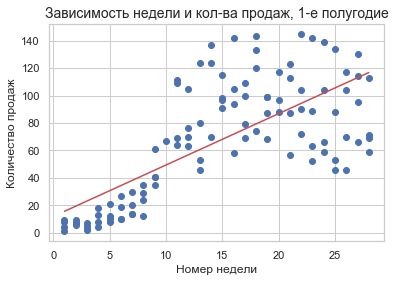

In [544]:
plt.plot(x, y, 'ob')
plt.plot(x1, y1, '-r')
plt.title("Зависимость недели и кол-ва продаж, 1-е полугодие", fontsize=14)
plt.xlabel("Номер недели")
plt.ylabel("Количество продаж")
plt.show()

Сделаем тоже самое для 2 - ого полугодия. Описав нисходящий тренд

In [545]:
f = df1.query('week_of_year > 28')['econom']
z = df1.query('week_of_year > 28')['week_of_year']
b1, b0, r, p, std_err = stats.linregress(z, f)
min = np.min(z)
max = np.max(z)
z1 = np.linspace(min, max)
f1 = b1 * z1 + b0


def lig2(z2):
    f2 = b1 * z2 + b0
    return f2


lig2(45)

16.268736899582535

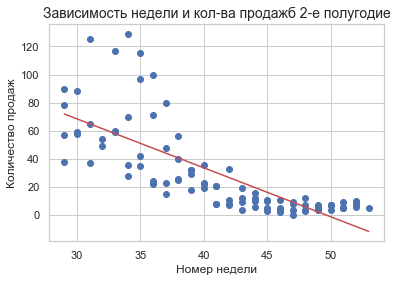

In [546]:
plt.plot(z, f, 'ob')
plt.plot(z1, f1, '-r')
plt.title("Зависимость недели и кол-ва продажб 2-е полугодие", fontsize=14)
plt.xlabel("Номер недели")
plt.ylabel("Количество продаж")
plt.show()

 <a name="4."><a/><br/>
    <font size ="5"><b>4. Общий вывод</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

1. В данных наблюдается сезонность. С потеплением растет и спрос
2. Устойчивый тренд роста к середине года и снижения к концу года
3. Оборачиваемость товаров ценовой группы econom - **64.9%** от общего оборота
4. Явная линейная зависимость роста и падения продаж с порядковым номером недели